# Entrono #

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.ensemble import GradientBoostingRegressor
from langchain.embeddings import SentenceTransformerEmbeddings
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.vectorstores import Chroma
import requests
import numpy as np
from fpdf import FPDF
import yfinance as yf
import pandas as pd
import ta
from datetime import datetime, timedelta
import seaborn as sns
from IPython.display import clear_outputv

In [5]:
# ----------------------------
# Pub/Sub Broker
# ----------------------------
class PubSubBroker:
    def __init__(self):
        self.subscribers = []

    def subscribe(self, callback):
        self.subscribers.append(callback)

    def publish(self, data):
        for callback in self.subscribers:
            callback(data)

# ----------------------------
# Whiteboard (memoria compartida)
# ----------------------------
class Whiteboard:
    def __init__(self):
        self.data = {}

    def write(self, key, value):
        self.data[key] = value

    def read(self):
        while len(self.data) < 2:
            print("Esperando datos en la pizarra... ", self.data)
            time.sleep(5)
        return dict(self.data)

    def clear(self):
        self.data = {}

# ----------------------------
# DataFetcher (Insertar agente de recolección de datos)
# ----------------------------
class DataFetcher:
    def __init__(self, df: pd.DataFrame = None):
        self.df = df if df is not None else self.fetch_and_process_data()
        self.index = 0

    def has_next(self):
        return self.index < len(self.df)

    def get_next_ticker(self):
        if self.index < len(self.df):
            return self.df.iloc[self.index]['Ticker']
        return None
    

    def fetch_data(self):
        current = self.df.iloc[self.index]
        self.index += 1
        return current

    def visualize_relationships(self):
        if self.df.empty:
            print("No hay datos para visualizar.")
            return

        df = self.df.copy()
        sns.set(style="whitegrid")
        plt.figure(figsize=(16, 10))

        plt.subplot(2, 2, 1)
        sns.scatterplot(x='RSI', y='Close', hue='Ticker', data=df)
        plt.title('Relación entre RSI y Close')

        plt.subplot(2, 2, 2)
        sns.scatterplot(x='MACD', y='Close', hue='Ticker', data=df)
        plt.title('Relación entre MACD y Close')

        plt.subplot(2, 2, 3)
        sns.lineplot(x='SMA_20', y='Close', hue='Ticker', data=df)
        plt.title('Relación entre SMA_20 y Close')

        plt.subplot(2, 2, 4)
        sns.boxplot(x='Ticker', y='Volume', data=df)
        plt.title('Distribución del Volumen por Ticker')

        plt.tight_layout()
        plt.show()

    def fetch_and_process_data(self):
        tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'BRK-B', 'TSLA', 'TSM', 'JPM']
        analysis_days = 5
        history_days = 15

        end_date = datetime.now()
        start_date = end_date - timedelta(days=history_days)

        raw_data = yf.download(
            tickers,
            start=start_date,
            end=end_date,
            interval="1h",
            auto_adjust=True,
            group_by='ticker',
            threads=True,
            progress=False,
            timeout=30
        )

        result = pd.DataFrame()

        for ticker in tickers:
            try:
                if ticker not in raw_data:
                    continue

                df = raw_data[ticker].copy()
                df = df.dropna(subset=['Close'])

                if len(df) < 50:
                    continue

                df.index = pd.to_datetime(df.index).tz_localize(None)

                df['RSI'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()
                df['SMA_20'] = ta.trend.SMAIndicator(df['Close'], window=20).sma_indicator()
                df['MACD'] = ta.trend.MACD(df['Close']).macd()

                try:
                    info = yf.Ticker(ticker).info
                    df['Ticker'] = ticker
                    df['Company Name'] = info.get('longName', ticker)
                    df['P/E Ratio'] = info.get('trailingPE', None)
                    df['Dividend Yield'] = info.get('dividendYield', None)
                except:
                    continue

                df = df[df.index.weekday < 5]

                unique_dates = df.index.normalize().unique()
                if len(unique_dates) >= analysis_days:
                    last_days = sorted(unique_dates, reverse=True)[:analysis_days]
                    df = df[df.index.normalize().isin(last_days)]
                else:
                    continue

                df = df.dropna(subset=['RSI', 'SMA_20', 'MACD'])

                column_order = [
                    'Ticker', 'Company Name', 'Open', 'High', 'Low', 'Close', 'Volume',
                    'RSI', 'SMA_20', 'MACD', 'P/E Ratio', 'Dividend Yield'
                ]
                df = df[column_order]

                if not df.empty:
                    df = df.dropna(axis=1, how='all')
                    if not df.empty and df.shape[1] > 0:
                        result = pd.concat([result, df], ignore_index=False)
            except:
                continue
        result.index = pd.to_datetime(result.index).tz_localize(None)
        return result.reset_index(drop=False)


In [6]:
class traditionalAgent:
    def __init__(self, broker, whiteboard, data_fetcher):
        self.train_df = None
        self.broker = broker
        self.whiteboard = whiteboard
        self.data_fetcher = data_fetcher
        self.df = None
        self.broker.subscribe(self.group_traditional)

    def set_dataframe(self, df):
        self.df = df
        
    def set_train_df(self, train_df):
        self.train_df = train_df

    def group_traditional(self, data):
        idx = self.data_fetcher.index
        if idx < 2 or self.df is None:
            self.whiteboard.write('trad_pred', data['Close'])
            return

        # Filtrar histórico por ticker actual
        df_hist = self.train_df[self.train_df['Ticker'] == data['Ticker']].copy()

        if len(df_hist) < 10:
            self.whiteboard.write('trad_pred', data['Close'])
            return

        # Columnas predictoras
        features = ['Open', 'High', 'Low', 'Volume', 'RSI', 'SMA_20', 'MACD']
        

        # Objetivo: Close futuro (t+1)
        df_hist['Close_Future'] = df_hist['Close'].shift(-1)
        df_hist = df_hist.dropna(subset=features + ['Close_Future'])

        if len(df_hist) < 10:
            self.whiteboard.write('trad_pred', data['Close'])
            return
        try:
            X = df_hist[features]
            y = df_hist['Close_Future']
            current_features = np.array([data[f] for f in features]).reshape(1, -1)

            # pred1: Regresión lineal multivariable
            model1 = LinearRegression()
            model1.fit(X, y)
            pred1 = model1.predict(current_features)[0]

            # pred2: Gradient Boosting multivariable
            model2 = GradientBoostingRegressor()
            model2.fit(X, y)
            pred2 = model2.predict(current_features)[0]

        except Exception:
            pred1 = pred2 = data['Close']

        avg = (pred1 + pred2) / 2
        self.whiteboard.write('trad_pred', avg)

In [7]:
class AgenteIA:
    def __init__(self, broker, whiteboard, data_fetcher):
        self.broker = broker
        self.whiteboard = whiteboard
        #self.broker.subscribe(self.group_ai)
        self.data_fetcher = data_fetcher

        # Inicializa embeddings y base de datos vectorial
        self.embedding_function = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")
        self.db = None  # Se cargará después con documentos reales

    def cargar_documentos(self, ruta):
        documentos = []
        for archivo in os.listdir(ruta):
            if archivo.endswith(".txt"):
                documentos.extend(TextLoader(os.path.join(ruta, archivo)).load())
            elif archivo.endswith(".pdf"):
                documentos.extend(PyPDFLoader(os.path.join(ruta, archivo)).load())
        return documentos

    def dividir_chunks(self, documentos):
        splitter = CharacterTextSplitter(chunk_size=500, chunk_overlap=50)
        return splitter.split_documents(documentos)

    def crear_o_cargar_chromadb(self, chunks, persist_directory="db_finanzas"):
        if not os.path.exists(persist_directory):
            self.db = Chroma.from_documents(chunks, self.embedding_function, persist_directory=persist_directory)
            self.db.persist()
        else:
            self.db = Chroma(persist_directory=persist_directory, embedding_function=self.embedding_function)

    def consulta_lmstudio(self, prompt):
        url = "http://localhost:1234/v1/chat/completions"
        headers = {"Content-Type": "application/json"}

        data = {
            "messages": [{
                "role": "system",
                "content": "Eres un asistente que responde SOLO con JSON, nunca expliques, nunca incluyas texto adicional.\n" + prompt
            }],
            "temperature": 0.1,
            "max_tokens": 1048
        }

        response = requests.post(url, headers=headers, json=data)
        return response.json()["choices"][0]["message"]["content"]

    def consulta_rag(self, pregunta):
        if self.db is None:
            raise Exception("La base de datos vectorial no ha sido cargada.")
        similares = self.db.similarity_search(pregunta, k=3)
        contexto = "\n\n".join([doc.page_content for doc in similares])

        prompt = f"""Con base en el siguiente contexto, responde la pregunta solo en formato JSON válido con claves 'fecha' y 'valor':

        Contexto:
        {contexto}

        Pregunta: {pregunta}
        """
        res = self.consulta_lmstudio(prompt)
        return res

    def group_ai(self, data):
        stock_symbol = data.get('Ticker')
        current_date = pd.to_datetime(data['Datetime'])
        df_stock = self.data_fetcher.df
        
        
        if current_date > pd.to_datetime("2025-07-22 00:00:00"):
            day_before = current_date - pd.Timedelta(days=1)
        else:
            day_before = pd.Timestamp("2025-07-17")
        df_filtrado = df_stock[(df_stock['Ticker'] == stock_symbol) & (pd.to_datetime(df_stock['Datetime']).dt.date == day_before.date())]
        
        if current_date < pd.to_datetime("2025-07-21"):
            self.whiteboard.write('ai_pred', data['Close'])  # fallback
            return

        df_historico = df_filtrado.sort_values(by='Datetime')
        texto_contexto_historico = df_historico.to_string(index=False)
        if self.data_fetcher.index > 1:
            last_close = self.data_fetcher.df.loc[self.data_fetcher.index - 2]['Close']
        else:
            last_close = data['Close']
            
        pregunta = f"""Dado el siguiente historial de precios del activo {stock_symbol}, ¿cuál sería una predicción razonable del valor de cierre para el día y la hora {current_date}?
        
        Historial:
        {texto_contexto_historico}
        
        No seas tan atrevido con las predicciónes, usa algoritmos de prediccion de la bolsa.

        Responde en formato JSON, un solo elemento con la siguiente estructura: {{ "fecha": "AAAA-MM-DD hh:mm ", "valor": <número> }} 
        """
        try:
            respuesta = self.consulta_rag(pregunta)
            resultado = eval(respuesta)

            avg = resultado['valor']
        except Exception as e:
            avg = last_close  # fallback
        self.whiteboard.read
        self.whiteboard.write('ai_pred', avg)

In [8]:
class DecisionAgent:
    def __init__(self, histories):
        self.histories = histories

    def calcular_mape(self, real, pred):
        real, pred = np.array(real), np.array(pred)
        return np.mean(np.abs((real - pred) / real)) * 100

    def evaluar_decisiones(self):
        decisiones = {}
        for ticker, history in self.histories.items():
            real = history['Real_Close'].iloc[1:]
            ai_pred = history['AI_Prediction'].iloc[1:]
            trad_pred = history['Trad_Prediction'].iloc[1:]
            mape = self.calcular_mape(real, ai_pred)

            last_ai_1 = ai_pred.iloc[-2]
            last_ai_2 = ai_pred.iloc[-1]
            last_trad_1 = trad_pred.iloc[-2]
            last_trad_2 = trad_pred.iloc[-1]

            # Movimiento según AI
            if last_ai_2 > last_ai_1:
                mov_ai = "Vender"
            elif last_ai_2 < last_ai_1:
                mov_ai = "Comprar"
            else:
                mov_ai = "Mantener"

            # Movimiento según predicción tradicional
            if last_trad_2 > last_trad_1:
                mov_trad = "Vender"
            elif last_trad_2 < last_trad_1:
                mov_trad = "Comprar"
            else:
                mov_trad = "Mantener"

            # Decisión combinada
            if mape > 10:
                decision = f"Predicción IA no confiable (MAPE={round(mape, 2)}%) - Sugerido por Trad: {mov_trad}"
            elif mov_ai == mov_trad:
                decision = f"{mov_ai} (IA y Tradicional coinciden)"
            else:
                decision = f"IA: {mov_ai}, Trad: {mov_trad} - Decisiones contradictorias"

            decisiones[ticker] = {
                'MAPE': round(mape, 2),
                'DECISION': decision
            }

        return decisiones


In [9]:
# ----------------------------
# MarketEnvironment
# ----------------------------
class MarketEnvironment:
    def __init__(self, df, train_df_global):
        self.df = DataFetcher().fetch_and_process_data()
        DataFetcher().visualize_relationships()
        self.data_fetcher = DataFetcher(df)
        self.broker = PubSubBroker()
        self.whiteboard = Whiteboard()
        self.histories = {}  # Diccionario para almacenar cada empresa

        # Agentes de predicción
        self.agentsTraditional = traditionalAgent(self.broker, self.whiteboard, self.data_fetcher)
        self.agentsIA = AgenteIA(self.broker, self.whiteboard, self.data_fetcher)
        self.agentsTraditional.set_dataframe(df)
        self.agentsTraditional.set_train_df(train_df_global)

        documentos = self.agentsIA.cargar_documentos("documentos")
        chunks = self.agentsIA.dividir_chunks(documentos)
        self.agentsIA.crear_o_cargar_chromadb(chunks)
        
        # Suscribir los grupos de agentes al broker
        self.broker.subscribe(self.agentsTraditional.group_traditional)
        self.broker.subscribe(self.agentsIA.group_ai)

    def run(self):
        tickers = self.df['Ticker'].unique().tolist()

        for ticker in tickers:
            print(f"Iniciando simulación para {ticker}...")

            df_ticker = self.df[self.df['Ticker'] == ticker].reset_index(drop=True)
            self.data_fetcher = DataFetcher(df_ticker)
            self.agentsTraditional.set_dataframe(df_ticker)

            self.histories[ticker] = pd.DataFrame(columns=['Datetime', 'Real_Close', 'Trad_Prediction', 'AI_Prediction'])

            # Primer paso: hacer la primera predicción (usando t)
            if not self.data_fetcher.has_next():
                continue
            current_data = self.data_fetcher.fetch_data()
            self.whiteboard.clear()
            self.broker.publish(current_data)
            last_prediction = self.whiteboard.read()  # ← esto reemplaza a last_data

            while self.data_fetcher.has_next():
                current_data = self.data_fetcher.fetch_data()
                # Guardar la predicción previa (hecha en t) contra el valor real de t+1
                self.histories[ticker].loc[len(self.histories[ticker])] = [
                    current_data['Datetime'],
                    current_data['Close'],
                    last_prediction.get('trad_pred', current_data['Close']),
                    last_prediction.get('ai_pred', current_data['Close'])
                ]
                #print(
                #    f"[{current_data['Datetime']}] {ticker} | "
                #    f"Real: {current_data['Close']:.2f} | "
                #    f"Tradicional: {last_prediction.get('trad_pred', current_data['Close']):.2f} | "
                #    f"IA: {last_prediction.get('ai_pred', current_data['Close']):.2f}"
                #)

                # Hacer predicción para t+2 usando datos de t+1
                self.whiteboard.clear()
                self.broker.publish(current_data)
                last_prediction = self.whiteboard.read()

            self.plot_graph(ticker)
            #self.histories[ticker].to_excel(f"simulacion_{ticker}.xlsx", index=False)
            print(f"✔ Terminó {ticker}")
        decision_agent = DecisionAgent(self.histories)
        decisiones = decision_agent.evaluar_decisiones()

        print("\n===== DECISIONES DE INVERSIÓN =====")
        # Crear PDF
        pdf = FPDF()
        pdf.add_page()
        pdf.set_font("Arial", size=12)
        pdf.cell(200, 10, txt="Resultados de MAPE y Recomendaciones", ln=True, align='C')
        pdf.ln(10)
        
        # En vez de print, escribir en PDF línea por línea
        for ticker, resultado in decisiones.items():
            linea = f"{ticker}: MAPE={resultado['MAPE']}% => {resultado['DECISION']}"
            pdf.cell(200, 10, txt=linea, ln=True)
        
        # Guardar el archivo
        pdf.output("resultados_mape.pdf")


    def plot_graph(self, ticker):
        history = self.histories[ticker]

        # Ignorar el primer punto
        history = history.iloc[1:]

        plt.figure(figsize=(12,5))
        plt.plot(history['Datetime'], history['Real_Close'], label='Precio Real', marker='o')
        plt.plot(history['Datetime'], history['Trad_Prediction'], label='Predicción Tradicional', linestyle='--', marker='x')
        plt.plot(history['Datetime'], history['AI_Prediction'], label='Predicción IA', linestyle='-.', marker='s')
        plt.legend()
        plt.title(f'Simulación Multiagente - {ticker}')
        plt.xlabel('Tiempo')
        plt.ylabel('Precio de Cierre')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.tight_layout()
        plt.show()


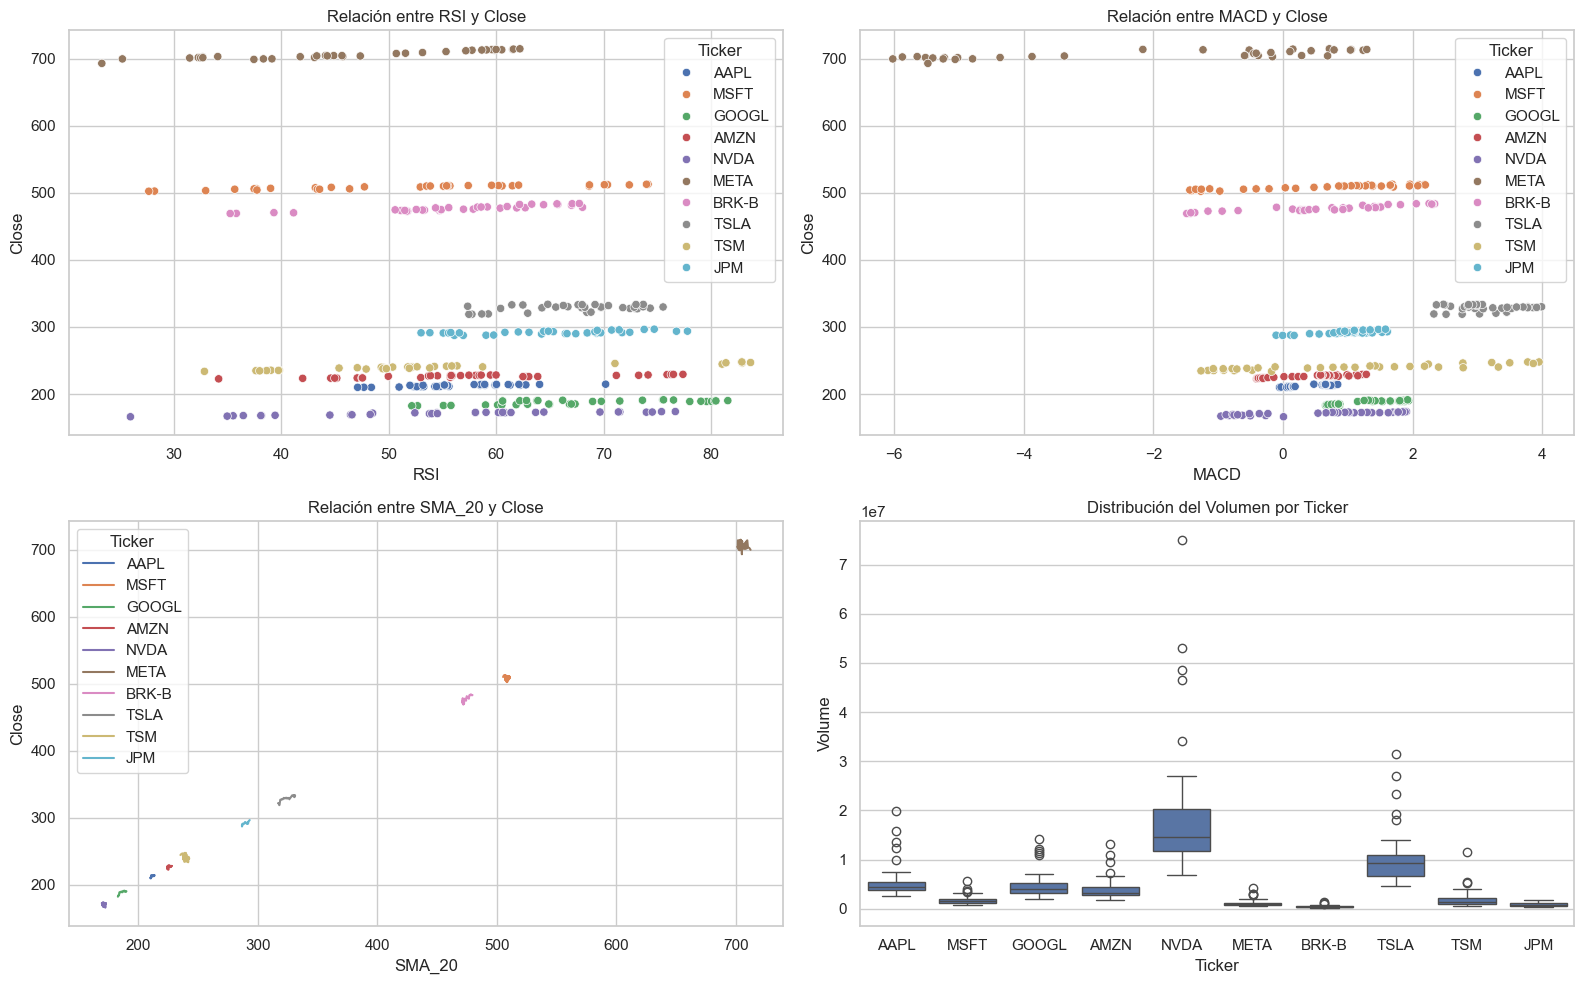

C:\Users\littl\AppData\Local\Temp\ipykernel_28456\2751206162.py:9: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  self.embedding_function = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")
d:\kike\Maestria\prueba\FUMU\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\littl\AppData\Local\Temp\ipykernel_28456\2751206162.py:30: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the

Iniciando simulación para AAPL...


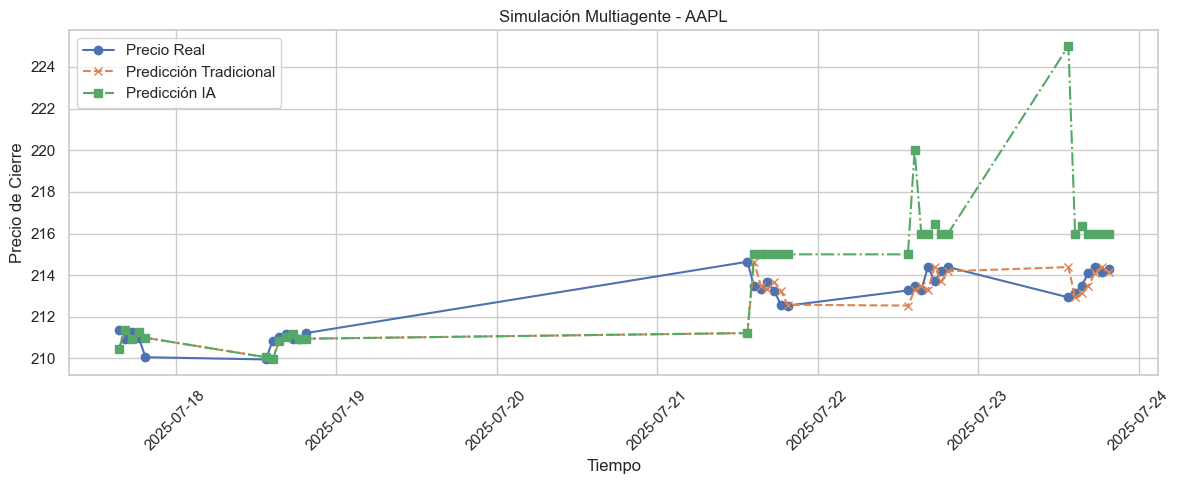

✔ Terminó AAPL
Iniciando simulación para MSFT...


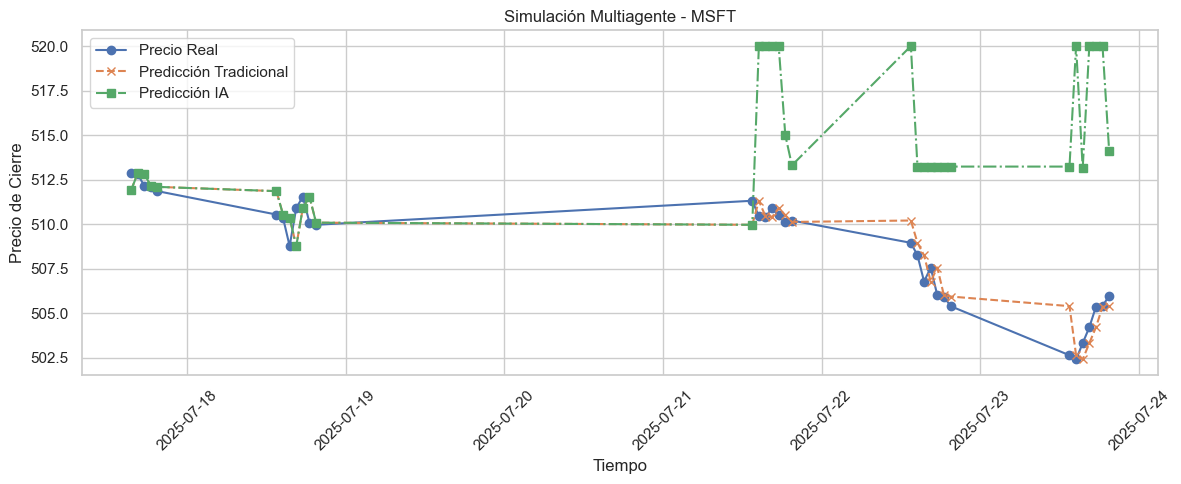

✔ Terminó MSFT
Iniciando simulación para GOOGL...


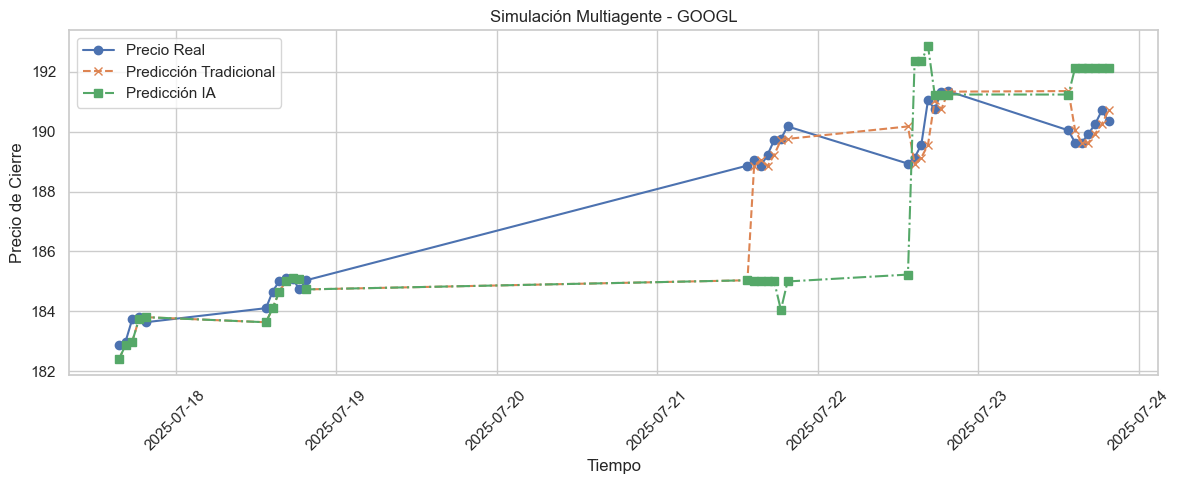

✔ Terminó GOOGL
Iniciando simulación para AMZN...


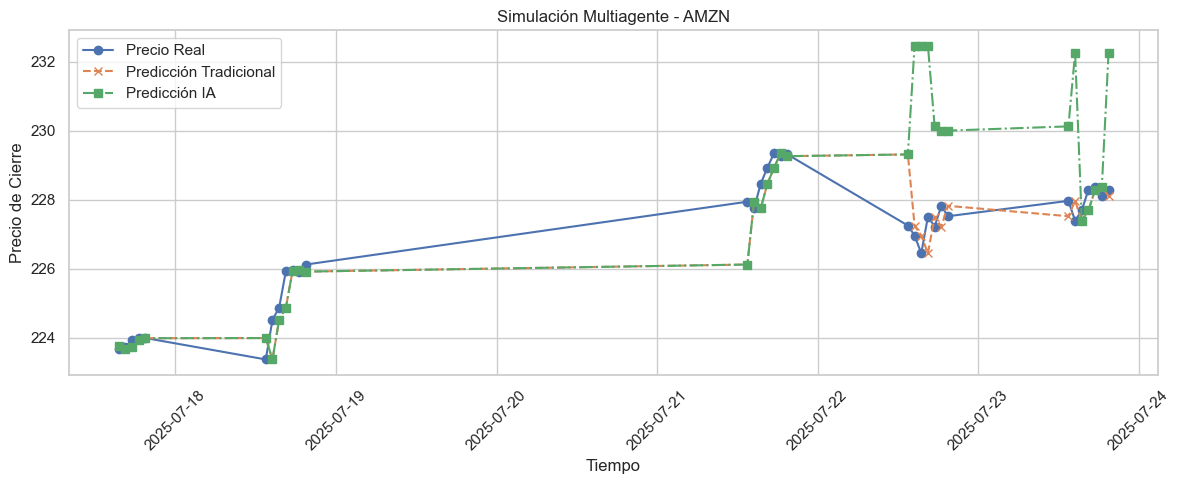

✔ Terminó AMZN
Iniciando simulación para NVDA...


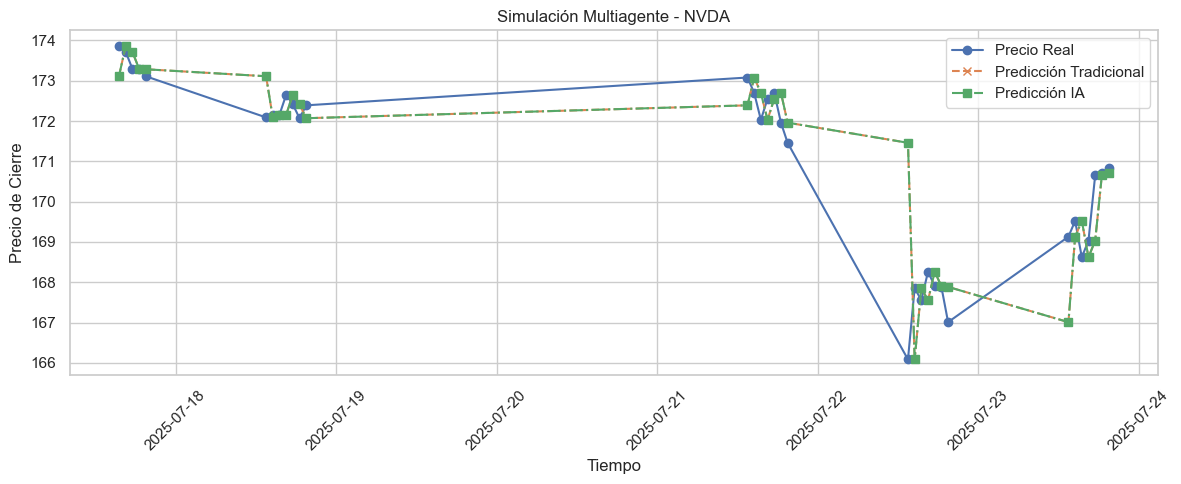

✔ Terminó NVDA
Iniciando simulación para META...


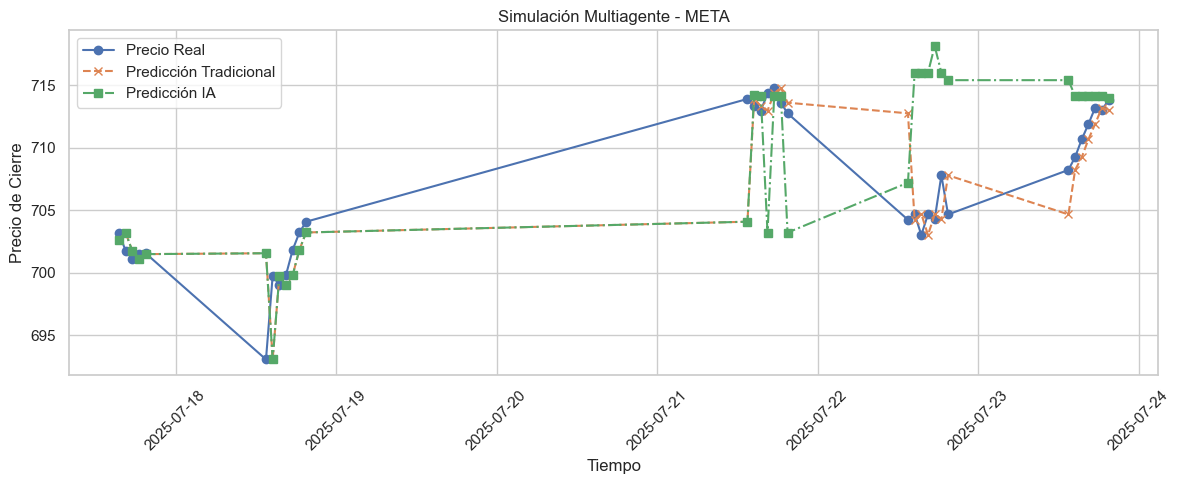

✔ Terminó META
Iniciando simulación para BRK-B...


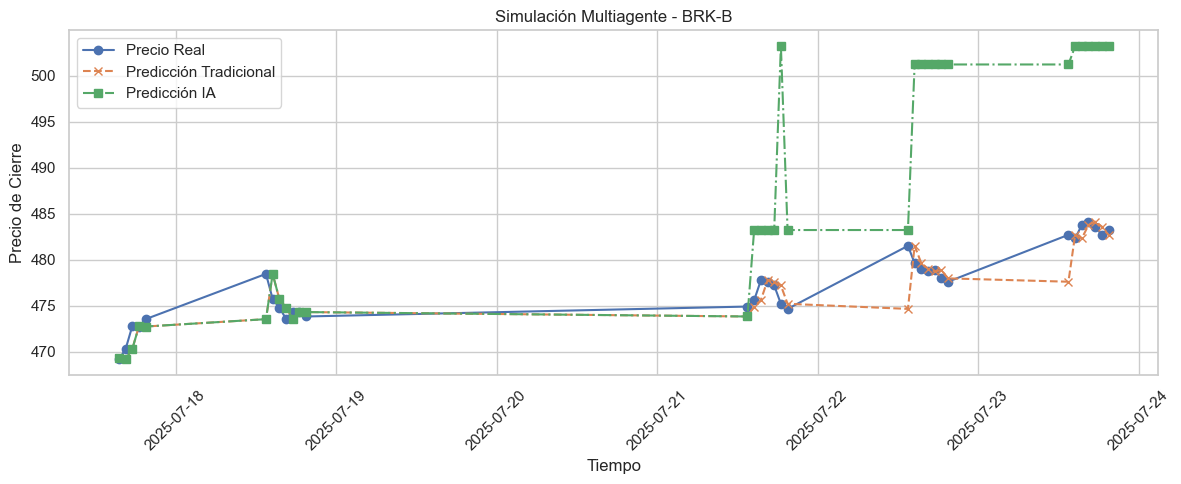

✔ Terminó BRK-B
Iniciando simulación para TSLA...


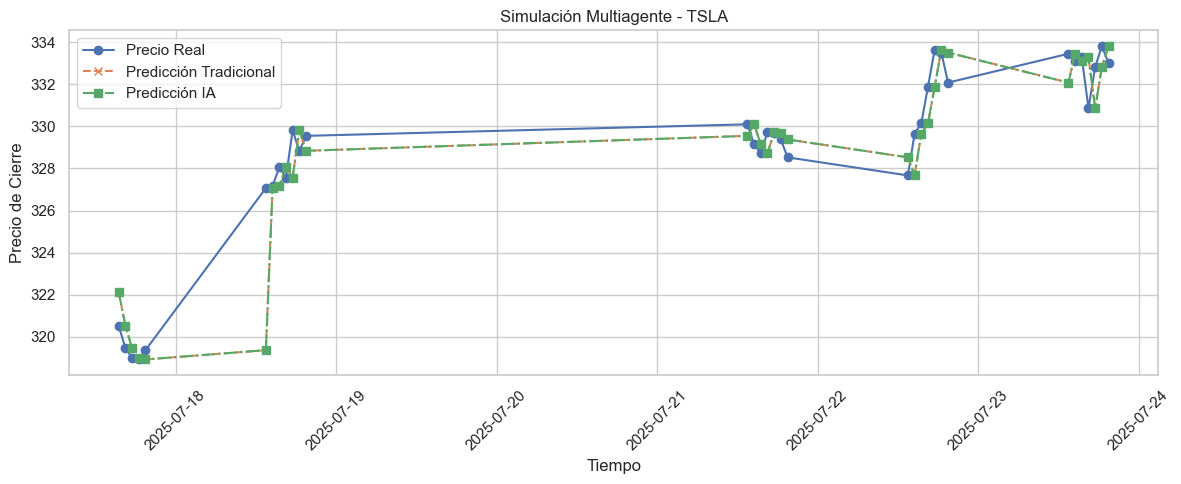

✔ Terminó TSLA
Iniciando simulación para TSM...


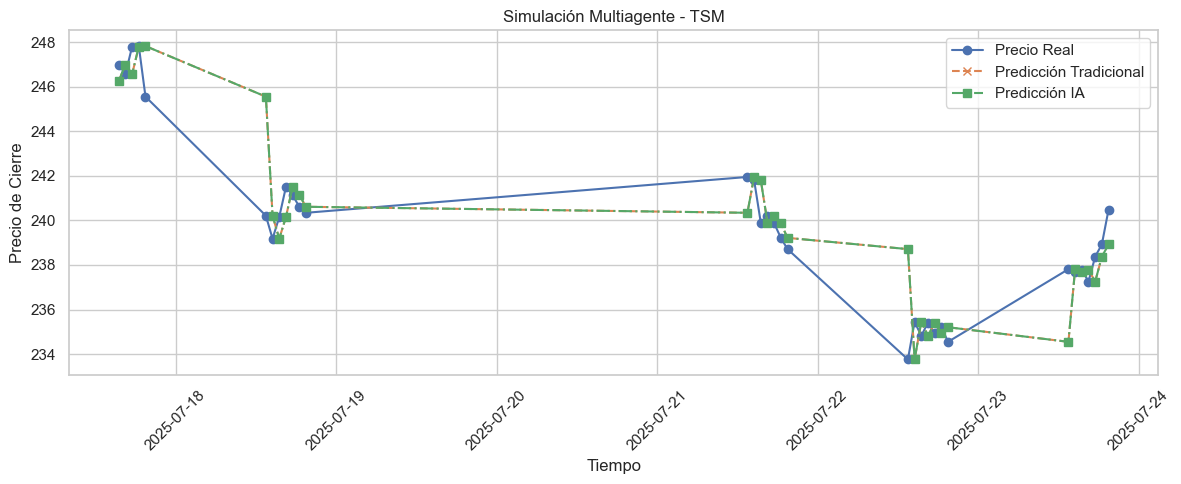

✔ Terminó TSM
Iniciando simulación para JPM...


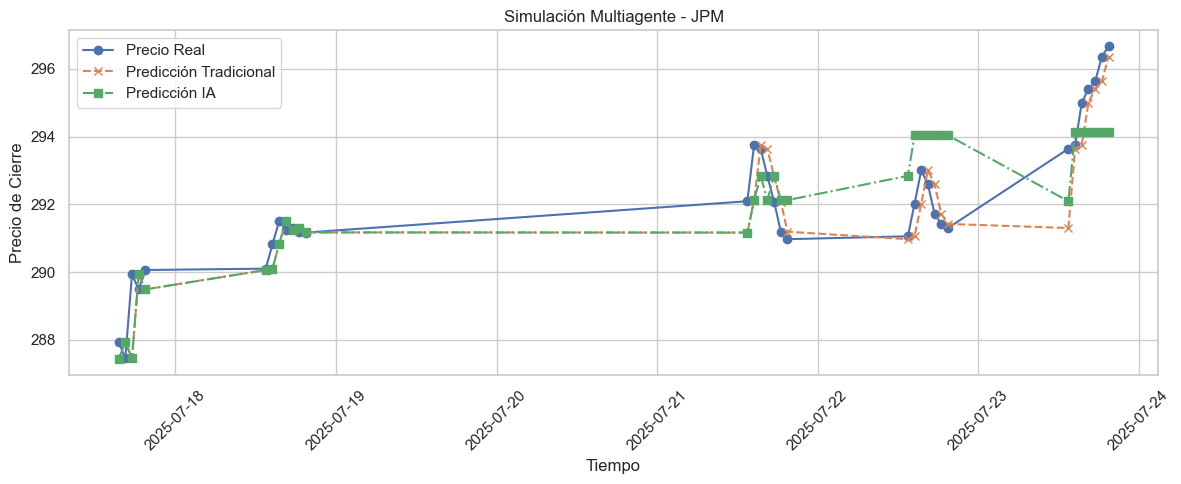

✔ Terminó JPM

===== DECISIONES DE INVERSIÓN =====


In [10]:
# ----------------------------
# Main
# ----------------------------
if __name__ == "__main__":
    # Cargar datos
    df = DataFetcher().fetch_and_process_data()
    train_df_global = pd.read_excel("data.xlsx")
    env = MarketEnvironment(df, train_df_global)
    env.run()